In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"]=(12,5) #dict chứa cấu hình mặc định của matplotlib - 12 width, 5 height
plt.rcParams["axes.grid"]=True #lưới nền

In [2]:
#Load & Clean data
elo=pd.read_csv(r"d:\nmit\ftuuu\XSTK\data bong da\EloRatings.csv")
matches=pd.read_csv(r"d:\nmit\ftuuu\XSTK\data bong da\Matches.csv")

#Drop missing critical fields
matches=matches.dropna(
    subset=["MatchDate","HomeTeam","AwayTeam","FTHome","FTAway"]
)
elo=elo.dropna(subset=["date","club","elo"])

#Convert datetime
elo["date"]=pd.to_datetime(elo["date"])
matches["date"]=pd.to_datetime(matches["MatchDate"])

print(elo)
print(matches)

C:\Users\Admin\AppData\Local\Temp\ipykernel_19904\3483698639.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  matches=pd.read_csv(r"d:\nmit\ftuuu\XSTK\data bong da\Matches.csv")


             date       club country      elo
0      2000-07-01     Aachen     GER  1453.60
1      2000-07-01    Aalborg     DEN  1482.61
2      2000-07-01      Aalst     BEL  1337.53
3      2000-07-01     Aarhus     DEN  1381.46
4      2000-07-01   Aberdeen     SCO  1360.43
...           ...        ...     ...      ...
245028 2025-06-01  Wolfsburg     GER  1645.72
245029 2025-06-01     Wolves     ENG  1735.76
245030 2025-06-01   Zaragoza     ESP  1450.09
245031 2025-06-01      Zenit     RUS  1654.94
245032 2025-06-01     Zwolle     NED  1462.81

[245033 rows x 4 columns]
       Division   MatchDate MatchTime   HomeTeam    AwayTeam  HomeElo  \
0            F1  2000-07-28       NaN  Marseille      Troyes  1686.34   
1            F1  2000-07-28       NaN   Paris SG  Strasbourg  1714.89   
2            F2  2000-07-28       NaN  Wasquehal       Nancy  1465.08   
3            F1  2000-07-29       NaN    Auxerre       Sedan  1635.58   
4            F1  2000-07-29       NaN   Bordeaux        

In [3]:
#Define timeline & Peak period
start="2007-01-01"
end="2023-12-31"

mu_peak_start="2007-08-01"
mu_peak_end="2008-05-31"

mc_peak_start="2022-08-01"
mc_peak_end="2023-06-30"

In [4]:
#Lọc matches theo team
def get_team_matches(team):
    return matches[
        ((matches["HomeTeam"]==team)|
         (matches["AwayTeam"]==team)) &
         (matches["MatchDate"].between(start,end))
    ].copy()

mu_matches=get_team_matches("Man United")
mc_matches=get_team_matches("Man City")

In [ ]:
#Match Features
def add_match_features(df,team,peak_start,peak_end):
    df=df.sort_values("MatchDate").copy()
    #Bàn thắng, thua theo team
    goals_for=np.where(
        df["HomeTeam"]==team,df["FTHome"],df["FTAway"]
    )
    goals_against=np.where(
        df["HomeTeam"]==team,df["FTAway"],df["FTHome"]
    )
    #Goal Diff
    df["Goal_Diff"]=goals_for-goals_against

    #Results
    df["Results"]=np.where(
        df["Goal_Diff"]>0,"W",
        np.where(df["Goal_Diff"]==0,"D","L")
    )
    
    #Points
    df["Points"]=df["Results"].map({"W":3,"D":1,"L":0})

    #PeakSeason
    df["PeakSeason"]=df["MatchDate"].between(peak_start,peak_end)

    return df

mu_matches=add_match_features(
    mu_matches,"Man United",mu_peak_start,mu_peak_end
)
mc_matches=add_match_features(
    mc_matches,"Man City",mc_peak_start,mc_peak_end
)



         MatchDate          HomeTeam          AwayTeam  FTHome  FTAway  Goal_Diff Results  Points  PeakSeason
38102   2007-01-01         Newcastle        Man United     2.0     2.0        0.0       D       1       False
38214   2007-01-13        Man United       Aston Villa     3.0     1.0        2.0       W       3       False
38406   2007-01-21           Arsenal        Man United     2.0     1.0       -1.0       L       0       False
38605   2007-01-31        Man United           Watford     4.0     0.0        4.0       W       3       False
38717   2007-02-04         Tottenham        Man United     0.0     4.0        4.0       W       3       False
38824   2007-02-10        Man United          Charlton     2.0     0.0        2.0       W       3       False
39167   2007-02-24            Fulham        Man United     1.0     2.0        1.0       W       3       False
39297   2007-03-03         Liverpool        Man United     0.0     1.0        1.0       W       3       False
39710   20

In [26]:
mu_features = mu_matches[
    ["MatchDate", "Goal_Diff", "Results", "Points", "PeakSeason"]
]

print(mu_features.to_string())

         MatchDate  Goal_Diff Results  Points  PeakSeason
38102   2007-01-01        0.0       D       1       False
38214   2007-01-13        2.0       W       3       False
38406   2007-01-21       -1.0       L       0       False
38605   2007-01-31        4.0       W       3       False
38717   2007-02-04        4.0       W       3       False
38824   2007-02-10        2.0       W       3       False
39167   2007-02-24        1.0       W       3       False
39297   2007-03-03        1.0       W       3       False
39710   2007-03-17        3.0       W       3       False
39914   2007-03-31        3.0       W       3       False
40089   2007-04-07       -1.0       L       0       False
40394   2007-04-17        2.0       W       3       False
40440   2007-04-21        0.0       D       1       False
40609   2007-04-28        2.0       W       3       False
40788   2007-05-05        1.0       W       3       False
40909   2007-05-09        0.0       D       1       False
40969   2007-0

In [27]:
def compact_summary(df):
    return pd.Series({
        "Matches": len(df),
        "Win %": (df["Results"]=="W").mean(),
        "Draw %": (df["Results"]=="D").mean(),
        "Loss %": (df["Results"]=="L").mean(),
        "Avg Points": df["Points"].mean(),
        "Avg Goal Diff": df["Goal_Diff"].mean(),
        "Best Win": df["Goal_Diff"].max(),
        "Worst Loss": df["Goal_Diff"].min()
    })

summary_compact = pd.DataFrame({
    "Man United": compact_summary(mu_matches),
    "Man City": compact_summary(mc_matches)
}).T

summary_compact


,Matches,Win %,Draw %,Loss %,Avg Points,Avg Goal Diff,Best Win,Worst Loss
Man United,645.0,0.589147,0.210853,0.200000,1.978295,0.817054,9.0,-7.0
Man City,644.0,0.625776,0.175466,0.198758,2.052795,1.166149,8.0,-7.0


In [6]:
#Descriptive Statistics
def season_summary(df):
    return{
        "Matches":len(df),
        "Wins":(df["Results"]=="W").sum(),
        "Draws":(df["Results"]=="D").sum(),
        "Losses":(df["Results"]=="L").sum(),
        "Points per match":df["Points"].mean()
    }

summary=pd.DataFrame(
    [season_summary(mu_matches),season_summary(mc_matches)],
    index=["Man United","Man City"]
)
summary

,Matches,Wins,Draws,Losses,Points per match
Man United,645,380,136,129,1.978295
Man City,644,403,113,128,2.052795


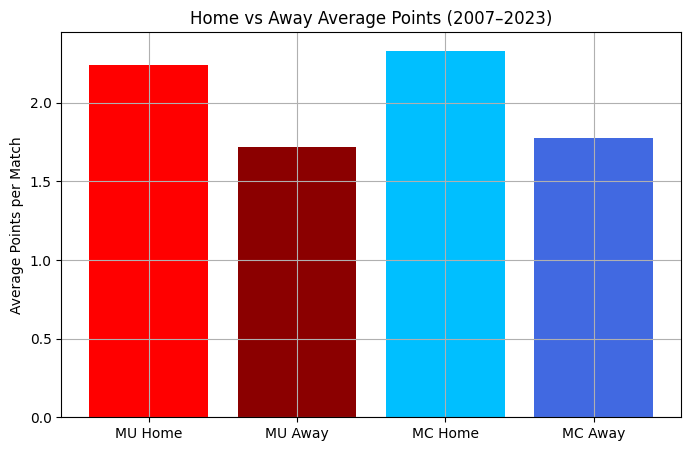

In [24]:
def add_home_away(df,team):
    df=df.copy()
    df["Venue"]=np.where(df["HomeTeam"]==team,"Home","Away")
    return df

mu_ha=add_home_away(mu_matches,"Man United")
mc_ha=add_home_away(mc_matches,"Man City")

ha_compare = pd.DataFrame({
    "MU Home": mu_ha[mu_ha["Venue"]=="Home"]["Points"].mean(),
    "MU Away": mu_ha[mu_ha["Venue"]=="Away"]["Points"].mean(),
    "MC Home": mc_ha[mc_ha["Venue"]=="Home"]["Points"].mean(),
    "MC Away": mc_ha[mc_ha["Venue"]=="Away"]["Points"].mean(),
}, index=["Avg Points"])

labels = ha_compare.columns.tolist()
values = ha_compare.loc["Avg Points"].values
colors = ["red", "darkred", "deepskyblue", "royalblue"]

plt.figure(figsize=(8,5))
plt.bar(labels, values, color=colors)

plt.title("Home vs Away Average Points (2007–2023)")
plt.ylabel("Average Points per Match")
plt.show()



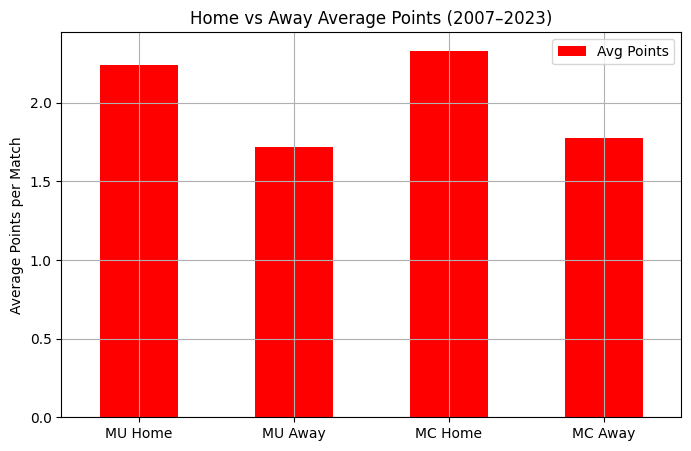

In [8]:
ha_compare.T.plot(
    kind="bar",
    figsize=(8,5),
    color=["red", "darkred", "deepskyblue", "royalblue"]
)

plt.title("Home vs Away Average Points (2007–2023)")
plt.ylabel("Average Points per Match")
plt.xticks(rotation=0)
plt.show()


Text(0.5, 1.0, 'Goal Difference Distribution')

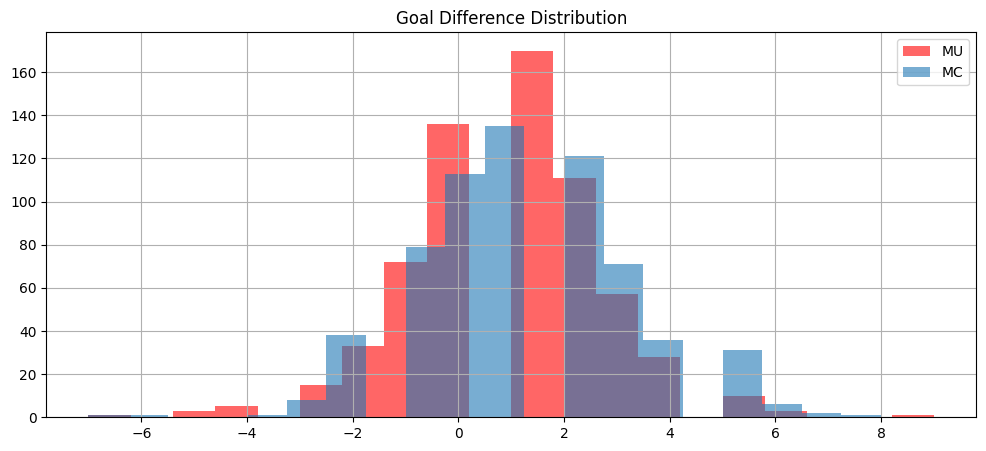

In [9]:
plt.hist(mu_matches["Goal_Diff"], bins=20, alpha=0.6, label="MU",color="red")
plt.hist(mc_matches["Goal_Diff"], bins=20, alpha=0.6, label="MC")
plt.legend()
plt.title("Goal Difference Distribution")


In [ ]:
def add_opponent_elo(df,elo):
    opp_elo = []
    for _, r in df.iterrows():
        opp = r["AwayTeam"] if r["HomeTeam"] == team else r["HomeTeam"]
        e = elo[(elo["club"]==opp) & (elo["date"]<=r["date"])]
        opp_elo.append(e.iloc[-1]["elo"] if not e.empty else np.nan)
    df["OppElo"] = opp_elo
    return df


TypeError: add_opponent_elo() missing 1 required positional argument: 'elo'

In [16]:
def peak_phase(df):
    df=df.copy()
    df["Era"]=np.where(df["PeakSeason"]==1,"Peak","Non-peak")
    return df

mu_era=peak_phase(mu_matches)
mc_era=peak_phase(mc_matches)

mu_era.groupby("Era")["Points"].mean()
mc_era.groupby("Era")["Points"].mean()

print(mu_era.groupby("Era")["Points"].mean())
print(mc_era.groupby("Era")["Points"].mean())


Era
Non-peak    1.958814
Peak        2.289474
Name: Points, dtype: float64
Era
Non-peak    2.034653
Peak        2.342105
Name: Points, dtype: float64


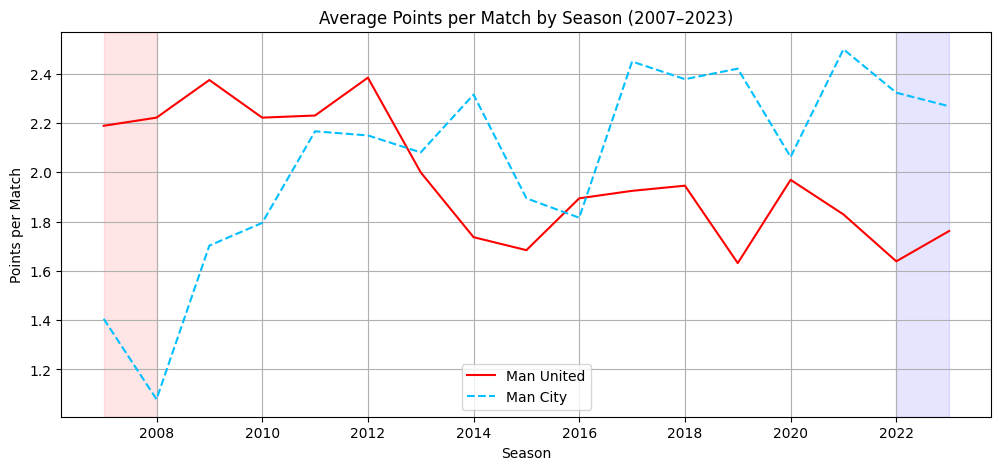

In [17]:
#Average Points per Match by season
def add_season(df):
    df=df.copy()
    df["Season"]=df["date"].dt.year
    return df

mu_s=add_season(mu_matches)
mc_s=add_season(mc_matches)

mu_season=mu_s.groupby("Season")["Points"].mean()
mc_season=mc_s.groupby("Season")["Points"].mean()

plt.figure(figsize=(12,5))
plt.plot(mu_season.index,mu_season.values,
         label="Man United",color="red")

plt.plot(mc_season.index,mc_season.values,
         label="Man City",color="deepskyblue", linestyle="--")

plt.axvspan(2007,2008,color="red",alpha=0.1)
plt.axvspan(2022,2023,color="blue",alpha=0.1)

plt.title("Average Points per Match by Season (2007–2023)")
plt.xlabel("Season")
plt.ylabel("Points per Match")
plt.legend()
plt.show()


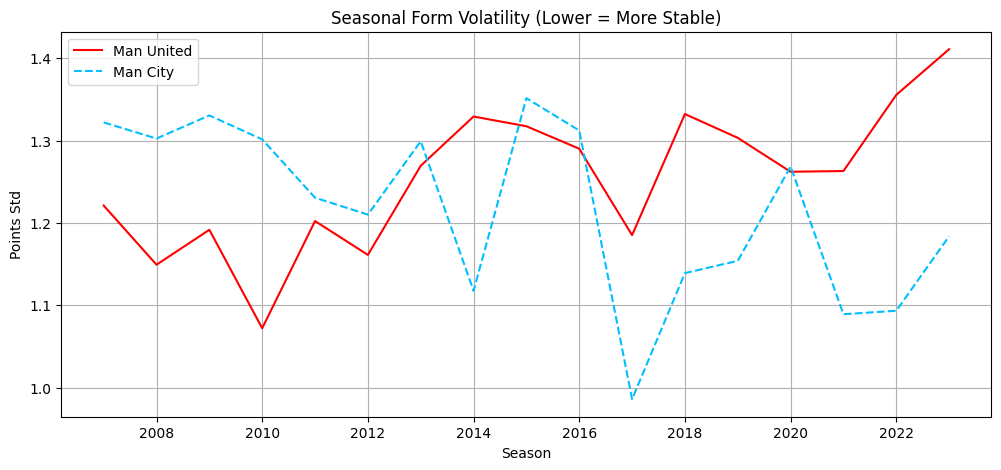

In [18]:
#Season Stability
def season_stability(df):
    return df.groupby(df["date"].dt.year)["Points"].std()

mu_stab = season_stability(mu_matches)
mc_stab = season_stability(mc_matches)

plt.figure(figsize=(12,5))
plt.plot(mu_stab, label="Man United", color="red")
plt.plot(mc_stab, label="Man City", color="deepskyblue", linestyle="--")

plt.title("Seasonal Form Volatility (Lower = More Stable)")
plt.xlabel("Season")
plt.ylabel("Points Std")
plt.legend()
plt.show()


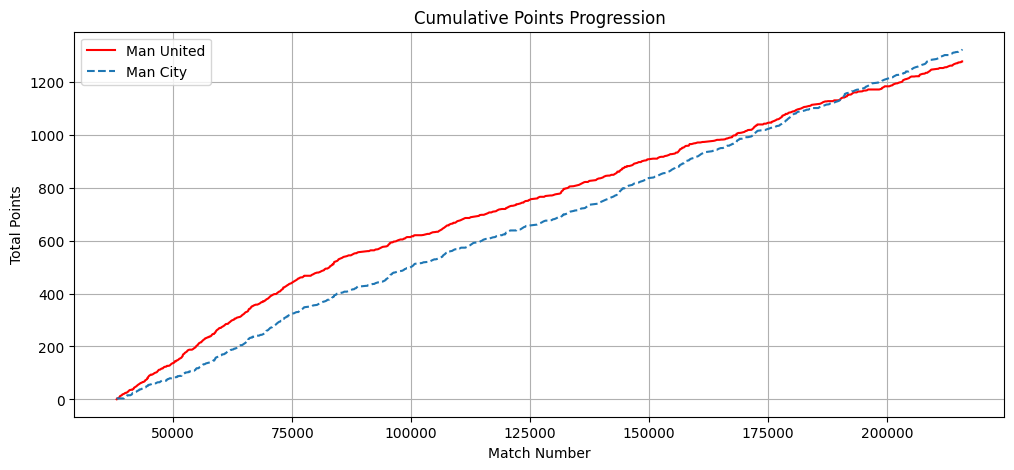

In [19]:
#Cumulative points
def plot_cumulative_points(mu, mc):
    mu["CumPoints"]=mu["Points"].cumsum()
    mc["CumPoints"]=mc["Points"].cumsum()

    plt.plot(mu["CumPoints"],label="Man United",color="red")
    plt.plot(mc["CumPoints"],label="Man City",linestyle="--")

    plt.title("Cumulative Points Progression")
    plt.xlabel("Match Number")
    plt.ylabel("Total Points")
    plt.legend()
    plt.show()

plot_cumulative_points(mu_matches,mc_matches)


In [20]:
def get_team_elo(team):
    return elo[
        (elo["club"]==team) &
        (elo["date"].between(start,end))
    ].sort_values("date")

mu_elo=get_team_elo("Man United")
mc_elo=get_team_elo("Man City")


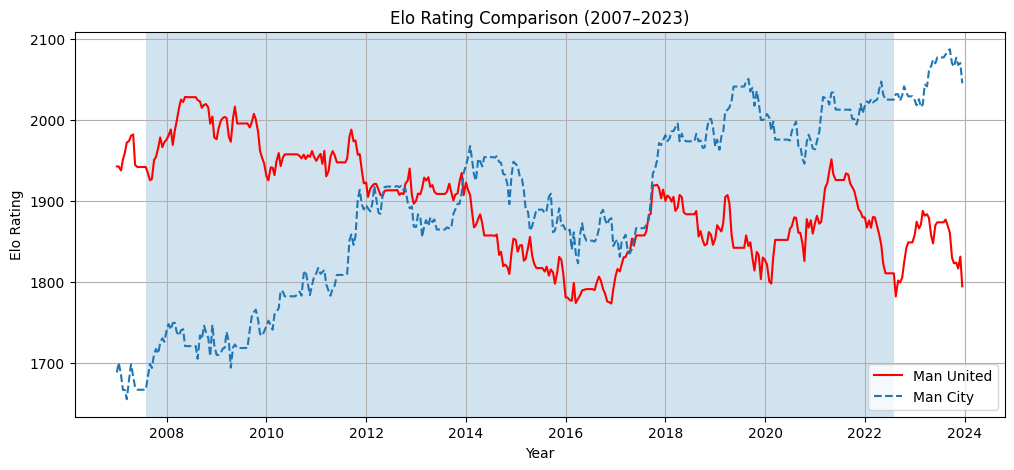

In [21]:
plt.plot(mu_elo["date"],mu_elo["elo"],label="Man United",color="red")
plt.plot(mc_elo["date"],mc_elo["elo"],label="Man City",linestyle="--")

plt.axvspan(mu_peak_start,mu_peak_end,alpha=0.2)
plt.axvspan(mc_peak_start,mu_peak_end,alpha=0.2)

plt.title("Elo Rating Comparison (2007–2023)")
plt.xlabel("Year")
plt.ylabel("Elo Rating")
plt.legend()
plt.show()
